In [2]:
import pandas as pd

# Load dataset
df = pd.read_csv(
    "Heart_Disease_Mortality_Data_Among_US_Adults__35___by_State_Territory_and_County___2018-2020.csv"
)


In [3]:
# Check shape and column names
print(df.shape)
print(df.columns)


(59094, 20)
Index(['Year', 'LocationAbbr', 'LocationDesc', 'GeographicLevel', 'DataSource',
       'Class', 'Topic', 'Data_Value', 'Data_Value_Unit', 'Data_Value_Type',
       'Data_Value_Footnote_Symbol', 'Data_Value_Footnote',
       'StratificationCategory1', 'Stratification1', 'StratificationCategory2',
       'Stratification2', 'TopicID', 'LocationID', 'Y_lat', 'X_lon'],
      dtype='object')


In [4]:
# Filter only county-level records
df = df[df["GeographicLevel"] == "County"]


In [5]:
# Drop rows with missing mortality rate
df = df[df["Data_Value"].notna()]


In [6]:
# Calculate median mortality rate
median_mortality = df["Data_Value"].median()

# Create binary target column
df["target"] = (df["Data_Value"] > median_mortality).astype(int)


In [7]:
# Remove continuous target column
df = df.drop(columns=["Data_Value"])


In [8]:
# Columns to drop (metadata / identifiers)
drop_cols = [
    "Data_Value_Unit",
    "Data_Value_Type",
    "Low_Confidence_Limit",
    "High_Confidence_Limit",
    "Topic",
    "TopicID",
    "DataSource",
    "LocationID"
]

df = df.drop(columns=drop_cols, errors="ignore")


In [9]:
# Rename columns for cleaner coding
df = df.rename(columns={
    "LocationAbbr": "state_abbr",
    "LocationDesc": "state_name",
    "GeographicLevel": "geo_level",
    "County": "county",
    "Race": "race",
    "Sex": "sex",
    "AgeGroup": "age_group"
})


In [10]:
# Check duplicate rows
print("Duplicate rows:", df.duplicated().sum())

# Remove duplicates
df = df.drop_duplicates()


Duplicate rows: 0


In [11]:
# Final overview
df.info()
df.head()


<class 'pandas.core.frame.DataFrame'>
Index: 32227 entries, 0 to 59069
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Year                        32227 non-null  int64  
 1   state_abbr                  32227 non-null  object 
 2   state_name                  32227 non-null  object 
 3   geo_level                   32227 non-null  object 
 4   Class                       32227 non-null  object 
 5   Data_Value_Footnote_Symbol  0 non-null      object 
 6   Data_Value_Footnote         0 non-null      object 
 7   StratificationCategory1     32227 non-null  object 
 8   Stratification1             32227 non-null  object 
 9   StratificationCategory2     32227 non-null  object 
 10  Stratification2             32227 non-null  object 
 11  Y_lat                       32227 non-null  float64
 12  X_lon                       32227 non-null  float64
 13  target                      32227 no

,Year,state_abbr,state_name,geo_level,Class,Data_Value_Footnote_Symbol,Data_Value_Footnote,StratificationCategory1,Stratification1,StratificationCategory2,Stratification2,Y_lat,X_lon,target
0,2019,AK,Aleutians East,County,Cardiovascular Diseases,NaN,NaN,Sex,Overall,Race/Ethnicity,Overall,55.442393,-161.959930,0
1,2019,AK,Aleutians West,County,Cardiovascular Diseases,NaN,NaN,Sex,Overall,Race/Ethnicity,Overall,53.648343,-166.917533,0
2,2019,AK,Anchorage,County,Cardiovascular Diseases,NaN,NaN,Sex,Overall,Race/Ethnicity,Overall,61.159145,-149.104559,0
3,2019,AK,Bethel,County,Cardiovascular Diseases,NaN,NaN,Sex,Overall,Race/Ethnicity,Overall,60.923648,-159.753262,1
5,2019,AK,Denali,County,Cardiovascular Diseases,NaN,NaN,Sex,Overall,Race/Ethnicity,Overall,63.678820,-149.960801,0


In [12]:
# Check class distribution
df["target"].value_counts()


,count
target,
0,16116
1,16111


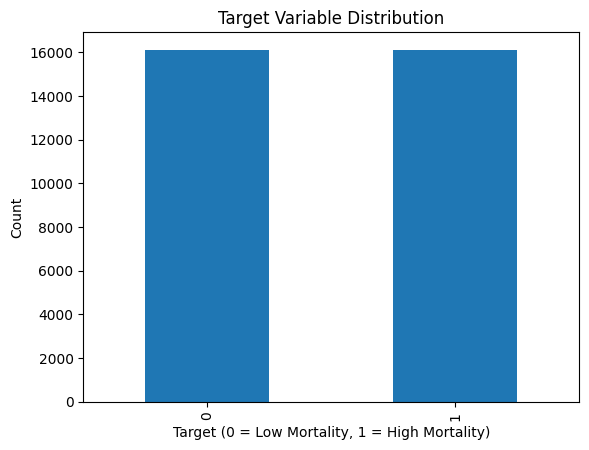

In [13]:
# Plot target distribution
import matplotlib.pyplot as plt

plt.figure()
df["target"].value_counts().plot(kind="bar")
plt.xlabel("Target (0 = Low Mortality, 1 = High Mortality)")
plt.ylabel("Count")
plt.title("Target Variable Distribution")
plt.show()


In [14]:
# Filter rows where stratification is Sex
df_sex = df[df["StratificationCategory1"] == "Sex"]

# Check mortality risk by sex
pd.crosstab(df_sex["Stratification1"], df_sex["target"], normalize="index")



target,0,1
Stratification1,,
Female,0.772259,0.227741
Male,0.236305,0.763695
Overall,0.504749,0.495251


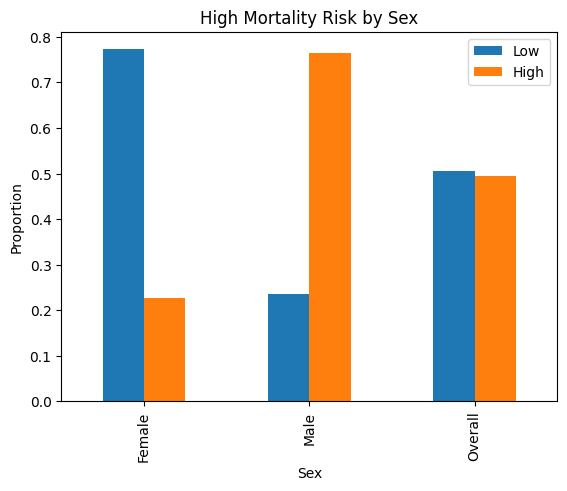

In [15]:
# Plot
import matplotlib.pyplot as plt

pd.crosstab(df_sex["Stratification1"], df_sex["target"], normalize="index").plot(kind="bar")
plt.xlabel("Sex")
plt.ylabel("Proportion")
plt.title("High Mortality Risk by Sex")
plt.legend(["Low", "High"])
plt.show()


In [16]:
# Check the exact category names available
print(df["StratificationCategory1"].value_counts())




StratificationCategory1
Sex    32227
Name: count, dtype: int64


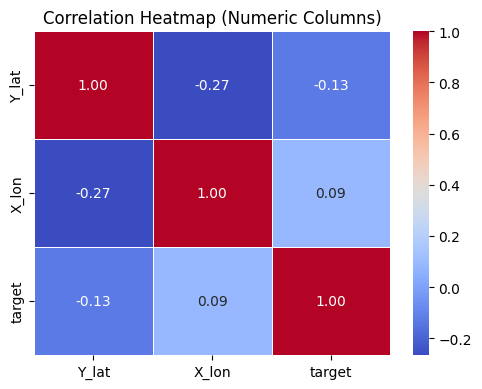

In [18]:
# -------------------------------
# Heatmap using numerical columns (excluding Year)
# -------------------------------

import seaborn as sns
import matplotlib.pyplot as plt

# Select numeric columns
numeric_df = df.select_dtypes(include=["int64", "float64"])

# Drop Year because it is a time index, not a true feature
numeric_df = numeric_df.drop(columns=["Year"])

# Compute correlation matrix
corr_matrix = numeric_df.corr()

# Plot heatmap
plt.figure(figsize=(5,4))
sns.heatmap(
    corr_matrix,
    annot=True,
    cmap="coolwarm",
    fmt=".2f",
    linewidths=0.5
)

plt.title("Correlation Heatmap (Numeric Columns)")
plt.tight_layout()
plt.show()


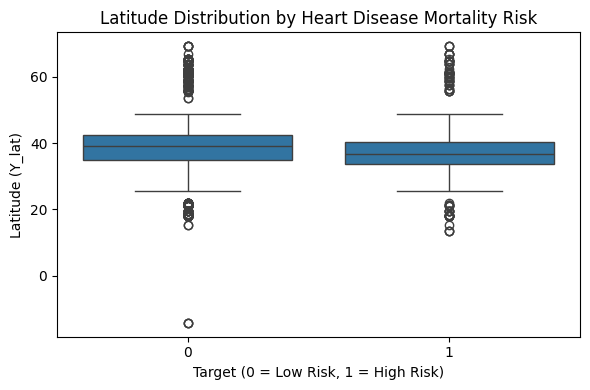

In [19]:
# -------------------------------
# Box plot: Latitude vs Mortality Risk
# -------------------------------

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))

# Box plot comparing latitude distribution by target class
sns.boxplot(
    x="target",
    y="Y_lat",
    data=df
)

plt.xlabel("Target (0 = Low Risk, 1 = High Risk)")
plt.ylabel("Latitude (Y_lat)")
plt.title("Latitude Distribution by Heart Disease Mortality Risk")
plt.tight_layout()
plt.show()


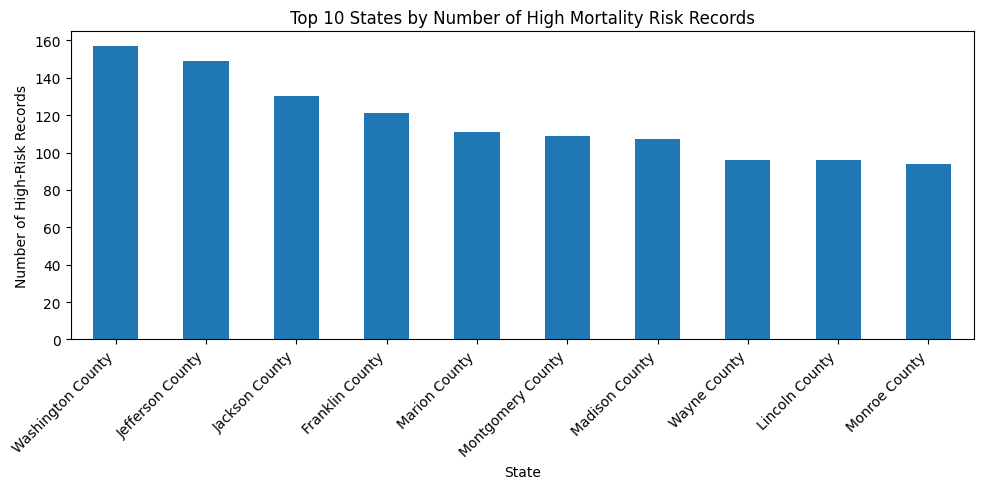

In [20]:
# -------------------------------
# Plot 1: Count of high-risk records by state
# -------------------------------

import matplotlib.pyplot as plt

# Count high-risk records per state
state_high_risk_counts = (
    df[df["target"] == 1]
    .groupby("state_name")
    .size()
    .sort_values(ascending=False)
)

# Plot top 10 states
plt.figure(figsize=(10,5))
state_high_risk_counts.head(10).plot(kind="bar")

plt.xlabel("State")
plt.ylabel("Number of High-Risk Records")
plt.title("Top 10 States by Number of High Mortality Risk Records")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()
